## <font color='red'>Import Library</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    precision_recall_fscore_support, roc_curve, average_precision_score, precision_recall_curve
)
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import randint, uniform
from sklearn.base import clone

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## <font color='red'>Load and Configure</font>

### <font color='blue'>Load file</font>

In [2]:
# Read the cleaned stroke dataset from the data folder
data = pd.read_csv("../data/cleaned_stroke.csv")

### <font color='blue'>Configure and Preprocess</font>

In [3]:
# Convert the target column "stroke" into binary values (Yes → 1, No → 0)
data["stroke"] = data["stroke"].replace({"Yes": 1, "No": 0}).astype(int)

# Separate features (X) and target (y)
X = data.drop("stroke", axis=1)
y = data["stroke"].astype(int)

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# Train-test split (stratified because stroke is imbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## <font color='red'>Random Forest Classifier</font>

In [4]:
# ----- Base model -----
rf = RandomForestClassifier(
    class_weight='balanced',  # keep this for imbalance
    random_state=42, n_jobs=-1
)

# ----- Hyperparameter search space (ranges of values to try) -----
param_dist = {
    "n_estimators": randint(200, 1200),
    "max_depth": randint(3, 40),              # None is powerful but try bounded depths
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "max_features": ["sqrt", "log2", None, 0.3, 0.5, 0.7],
    "bootstrap": [True, False]
}

# Stratified 5-fold cross-validation ensures each fold keeps class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For imbalance
scoring = {'pr_auc': 'average_precision', 'roc': 'roc_auc', 'rec': 'recall'}

# Randomized Search to quickly explore a wide range of parameter values
rand = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=60, scoring=scoring, refit='pr_auc',  # try "f1", "balanced_accuracy", or "roc_auc"
    cv=cv, verbose=1, n_jobs=-1, random_state=42
)

# Fit the random search model
rand.fit(X_train, y_train)
best_rf = rand.best_estimator_

# Display best settings and performance
print("Best params (random search):", rand.best_params_)
print("CV best score (pr_auc):", rand.best_score_)

# Get index of the best model and print detailed metrics
bi = rand.best_index_
print("Best PR-AUC:", rand.cv_results_['mean_test_pr_auc'][bi])
print("Best ROC-AUC:", rand.cv_results_['mean_test_roc'][bi])
print("Best Recall:", rand.cv_results_['mean_test_rec'][bi])

# ----- small GridSearch around the best -----
grid_params = {
    "n_estimators": [best_rf.n_estimators-100, best_rf.n_estimators, best_rf.n_estimators+100],
    "max_depth": [max(3, (best_rf.max_depth or 0)-5), best_rf.max_depth, (None if best_rf.max_depth is None else best_rf.max_depth+5)],
    "min_samples_split": [max(2, best_rf.min_samples_split-2), best_rf.min_samples_split, best_rf.min_samples_split+2],
    "min_samples_leaf": [max(1, best_rf.min_samples_leaf-1), best_rf.min_samples_leaf, best_rf.min_samples_leaf+1],
    "max_features": [best_rf.max_features]
}

# Remove any invalid configurations
grid_params = {k: [v for v in vs if v is not None or k=="max_depth"] for k,vs in grid_params.items()}

# Perform the more focused Grid Search
grid = GridSearchCV(best_rf, param_grid=grid_params, refit="pr_auc", cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Final optimized Random Forest model
final_rf = grid.best_estimator_
print("Best params (grid refine):", grid.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params (random search): {'bootstrap': True, 'max_depth': 29, 'max_features': 0.7, 'min_samples_leaf': 13, 'min_samples_split': 10, 'n_estimators': 458}
CV best score (pr_auc): 0.19530807708303405
Best PR-AUC: 0.19530807708303405
Best ROC-AUC: 0.8359546358132477
Best Recall: 0.5074358974358975
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params (grid refine): {'max_depth': 24, 'max_features': 0.7, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 458}


ROC-AUC (RF) = 0.819
PR-AUC  (RF) = 0.216


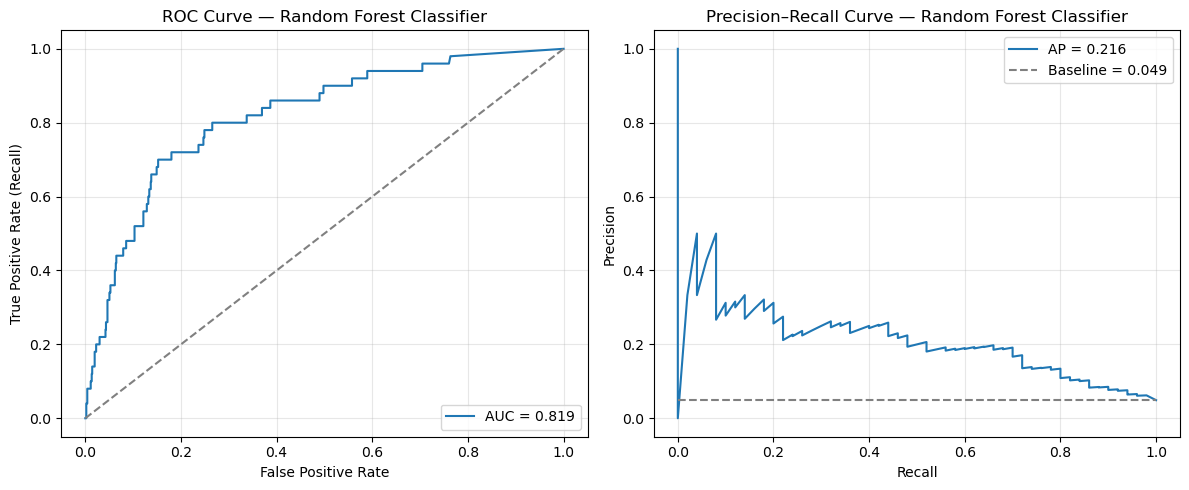

In [5]:
# Make class predictions on the test set (0 = No Stroke, 1 = Stroke)
y_pred = final_rf.predict(X_test)

# Get predicted probabilities for the positive class (Stroke = 1)
y_proba = final_rf.predict_proba(X_test)[:,1]

# # =============================
# # Plot Probability Distribution (For Checking)
# # =============================
# plt.figure(figsize=(6,4))
# plt.hist(y_proba, bins=50, color='steelblue', edgecolor='black')
# plt.xlabel("Predicted Probability (Stroke)")
# plt.ylabel("Count")
# plt.title("Probability Distribution of Model Outputs")
# plt.tight_layout()
# plt.show()

# ----- ROC Curve -----
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# ----- Precision-Recall Curve -----
prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)   # This *is* PR-AUC

print(f"ROC-AUC (RF) = {roc_auc:.3f}")
print(f"PR-AUC  (RF) = {pr_auc:.3f}")

# Baseline positive prevalence
pos_rate = (y_test == 1).mean()

plt.figure(figsize=(12,5))

# --- ROC Curve subplot ---
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.title("ROC Curve — Random Forest Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# --- Precision-Recall Curve subplot ---
plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"AP = {pr_auc:.3f}")
plt.hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--", label=f"Baseline = {pos_rate:.3f}")
plt.title("Precision–Recall Curve — Random Forest Classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# ========= 1) Find best threshold using F1 for the positive class (Stroke = 1) =========

thresholds = np.round(np.linspace(0.30, 0.70, 41), 2)
best_t = None
best_f1 = -1
best_cm = None
y_pred_best = None

for t in thresholds:
    y_pred_thresh = (y_proba > t).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred_thresh)

    # Keep the threshold that gives the highest F1
    if f1 > best_f1:
        best_f1 = f1
        best_t = t
        best_cm = cm
        y_pred_best = y_pred_thresh
        
# Report best threshold and metrics at that point
print(f"Best Threshold = {best_t} (F1 = {best_f1:.3f})")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.3f}")

# Confusion matrix and full classification report at the best threshold
print("\nConfusion Matrix - Random Forest Classifier (Best Threshold):\n", best_cm)
print("\nClassification Report - Random Forest Classifier (Best Threshold):\n", 
      classification_report(
          y_test, 
          y_pred_best,
          target_names=["No Stroke", "Stroke"],
          digits=3
      ))

# ========= 2) Print metrics across multiple thresholds to see trade-offs =========
print("\n===== Testing Different Decision Thresholds =====")
for t in thresholds:
    y_pred_thresh = (y_proba > t).astype(int)

    acc = accuracy_score(y_test, y_pred_thresh)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average="binary", zero_division=0)
    
    # Confusion matrix at this threshold
    cm = confusion_matrix(y_test, y_pred_thresh)

    print(f"\n=== Threshold = {t} ===")
    print(f"Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
    print("Confusion Matrix:\n", cm)

Best Threshold = 0.57 (F1 = 0.319)
Accuracy: 0.908

Confusion Matrix - Random Forest Classifier (Best Threshold):
 [[906  66]
 [ 28  22]]

Classification Report - Random Forest Classifier (Best Threshold):
               precision    recall  f1-score   support

   No Stroke      0.970     0.932     0.951       972
      Stroke      0.250     0.440     0.319        50

    accuracy                          0.908      1022
   macro avg      0.610     0.686     0.635      1022
weighted avg      0.935     0.908     0.920      1022


===== Testing Different Decision Thresholds =====

=== Threshold = 0.3 ===
Acc: 0.759 | Prec: 0.137 | Rec: 0.740 | F1: 0.231
Confusion Matrix:
 [[739 233]
 [ 13  37]]

=== Threshold = 0.31 ===
Acc: 0.766 | Prec: 0.138 | Rec: 0.720 | F1: 0.232
Confusion Matrix:
 [[747 225]
 [ 14  36]]

=== Threshold = 0.32 ===
Acc: 0.773 | Prec: 0.142 | Rec: 0.720 | F1: 0.237
Confusion Matrix:
 [[754 218]
 [ 14  36]]

=== Threshold = 0.33 ===
Acc: 0.788 | Prec: 0.151 | Rec: 0.72

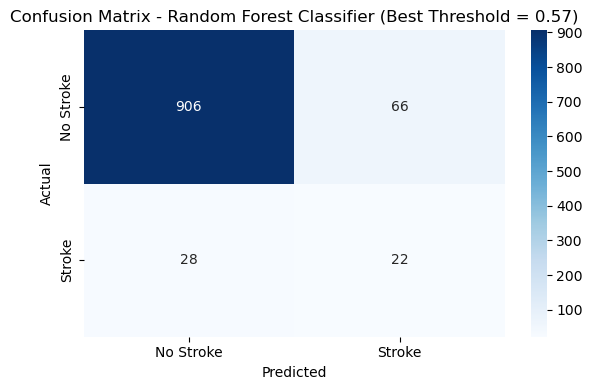

In [7]:
# 2) Plot confusion matrix for the BEST threshold
plt.figure(figsize=(6,4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Stroke", "Stroke"],
            yticklabels=["No Stroke", "Stroke"])
plt.title(f"Confusion Matrix - Random Forest Classifier (Best Threshold = {best_t})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Top 10 Important Features (RFC - Permutation Importance):
age: 0.148
avg_glucose_level: 0.040
work_type_Self-employed: 0.006
work_type_Government: 0.005
diabetes_category_Normal: 0.005
heart_disease_Yes: 0.003
smoking_status_Smoker: 0.002
age_group_35-39: 0.000
age_group_70-74: 0.000
bmi_category_Underweight: 0.000


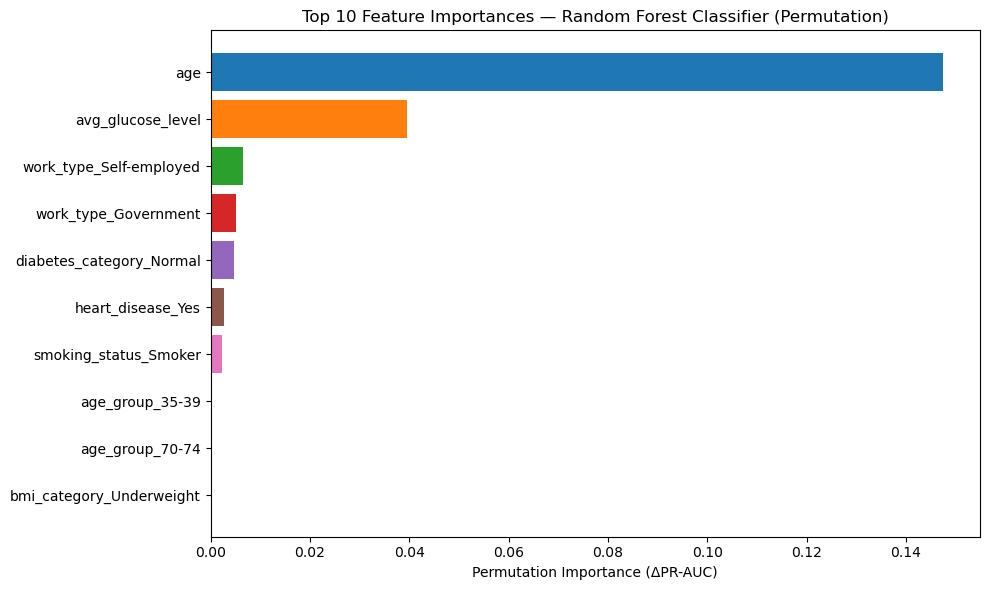

In [8]:
# ----- Permutation Importance using PR-AUC (more suitable for imbalanced data) -----

# Compute permutation importance on the TEST set
# - scoring="average_precision" evaluates drop in PR-AUC when each feature is shuffled
# - n_repeats controls how many shuffles per feature (more = stabler but slower)
# - Using X_test avoids train-leakage; random_state for reproducibility
result = permutation_importance(
    final_rf, X_test, y_test,
    scoring="average_precision",  # PR-AUC
    n_repeats=15, random_state=42, n_jobs=-1
)

# Mean importance across repeats (higher = feature more important)
imp = result.importances_mean

# Indices of the top 10 features, sorted by importance (descending)
indices = np.argsort(imp)[::-1][:10]

# Map indices back to feature names and values
top_features = X.columns[indices]
top_values = imp[indices]

# ----- Plot the top 10 permutation importances -----
print("Top 10 Important Features (RFC - Permutation Importance):")
for name, val in zip(top_features, top_values):
    print(f"{name}: {val:.3f}")

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(top_features)))
plt.barh(top_features, top_values, color=colors)
plt.xlabel("Permutation Importance (ΔPR-AUC)")
plt.title("Top 10 Feature Importances — Random Forest Classifier (Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## <font color='red'>Deep Learning (MLP)</font>

In [9]:
# ============================
# Baseline vs Tuned MLP (Loss curves + Test metrics)
# ============================
# ----------------------------
# Reproducibility
# ----------------------------
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

# ----------------------------
# Class weights
# ----------------------------
try:
    class_weight  # noqa: F401
except NameError:
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    
    # Weight the minority class higher
    class_weight = {0: 1.0, 1: float(neg) / float(pos)} if pos > 0 else {0:1.0, 1:1.0}
print("Class weights:", class_weight)

# ----------------------------
# Model factory
# ----------------------------
def build_mlp(units=(128, 64, 32), drop=(0.3, 0.3, 0.2), lr=0.003, d=None):
    if d is None:
        d = X_train.shape[1]
    inputs = layers.Input(shape=(d,))
    x = layers.Dense(units[0], activation="relu")(inputs); x = layers.BatchNormalization()(x); x = layers.Dropout(drop[0])(x)
    x = layers.Dense(units[1], activation="relu")(x);      x = layers.BatchNormalization()(x); x = layers.Dropout(drop[1])(x)
    x = layers.Dense(units[2], activation="relu")(x);      x = layers.BatchNormalization()(x); x = layers.Dropout(drop[2])(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    # Track both ROC-AUC and PR-AUC; optimize BCE
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(curve="ROC", name="AUC_ROC"),
                 keras.metrics.AUC(curve="PR",  name="AUC_PR")]
    )
    return model

# ----------------------------
# Shared callbacks (early stop + learning rate schedule)
# ----------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_AUC_PR", mode="max", patience=15, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_AUC_PR", mode="max", factor=0.5, patience=7, min_lr=0.0005
)

# ----------------------------
# 1) BASELINE TRAIN
# ----------------------------
baseline_cfg = dict(units=(128,64,32), drop=(0.3,0.3,0.2), lr=0.003, batch_size=256, epochs=200, val_split=0.1)
tf.keras.backend.clear_session()
baseline_model = build_mlp(units=baseline_cfg["units"], drop=baseline_cfg["drop"], lr=baseline_cfg["lr"])
history_baseline = baseline_model.fit(
    X_train, y_train,
    validation_split=baseline_cfg["val_split"],
    epochs=baseline_cfg["epochs"],
    batch_size=baseline_cfg["batch_size"],
    verbose=1,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr]
)

# ----------------------------
# 2) SIMPLE TUNING (select by max val_AUC_PR)
# ----------------------------
search_space = [
    # (units,            dropout,            lr,     batch_size)
    ((128, 64, 32),     (0.3, 0.3, 0.2),    0.003,  256),
    ((256, 128, 64),    (0.4, 0.3, 0.2),    0.003,  256),
    ((256, 128, 64),    (0.4, 0.3, 0.2),    0.001,  256),
    ((128, 64, 32),     (0.5, 0.4, 0.3),    0.001,  512),
    ((192, 96, 48),     (0.4, 0.3, 0.2),    0.002,  256),
]

best_score = -np.inf
best_cfg = None
best_model_tuned = None
best_hist = None

for units, drop, lr, bs in search_space:
    tf.keras.backend.clear_session()
    model = build_mlp(units=units, drop=drop, lr=lr)
    hist = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=200,
        batch_size=bs,
        verbose=0,
        class_weight=class_weight,
        callbacks=[early_stop, reduce_lr]
    )

    # Use the best validation PR-AUC seen during training as the selection score
    score = float(np.max(hist.history["val_AUC_PR"]))  
    best_epoch = int(np.argmax(hist.history["val_AUC_PR"])) + 1 # +1 for human-readable index
    
    # Keep this config if it beats the current best
    if score > best_score:
        best_score = score
        best_cfg = dict(units=units, drop=drop, lr=lr, batch_size=bs, best_epoch=best_epoch)
        best_model_tuned = model
        best_hist = hist

print("Best tuned config:", best_cfg)
print(f"Best val_AUC_PR: {best_score:.3f}")

# ----------------------------
# 3) REFIT TUNED MODEL (fresh history for clean plots)
# ----------------------------
tf.keras.backend.clear_session()
final_tuned_model = build_mlp(**{k: best_cfg[k] for k in ["units","drop","lr"]})
history_tuned = final_tuned_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=best_cfg["batch_size"],
    verbose=1,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr]
)

Class weights: {0: 1.0, 1: 19.537688442211056}

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC_PR: 0.1079 - AUC_ROC: 0.7128 - loss: 1.2648 - val_AUC_PR: 0.1786 - val_AUC_ROC: 0.8277 - val_loss: 0.5454 - learning_rate: 0.0030
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC_PR: 0.1635 - AUC_ROC: 0.8283 - loss: 1.0454 - val_AUC_PR: 0.1869 - val_AUC_ROC: 0.8326 - val_loss: 0.4570 - learning_rate: 0.0030
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC_PR: 0.1627 - AUC_ROC: 0.8292 - loss: 0.9955 - val_AUC_PR: 0.2146 - val_AUC_ROC: 0.8376 - val_loss: 0.4059 - learning_rate: 0.0030
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC_PR: 0.1931 - AUC_ROC: 0.8508 - loss: 0.9269 - val_AUC_PR: 0.2118 - val_AUC_ROC: 0.8413 - val_loss: 0.3833 - learning_rate: 0.0030
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC_PR: 0.2038 - AUC_ROC: 0.8505 - loss: 0.9177 - val_AUC_PR: 0.1872 - val_AUC_ROC: 0.8394 - val_loss: 0.3656 - learning_rate: 0.0030
Epoch 6/200
15/1

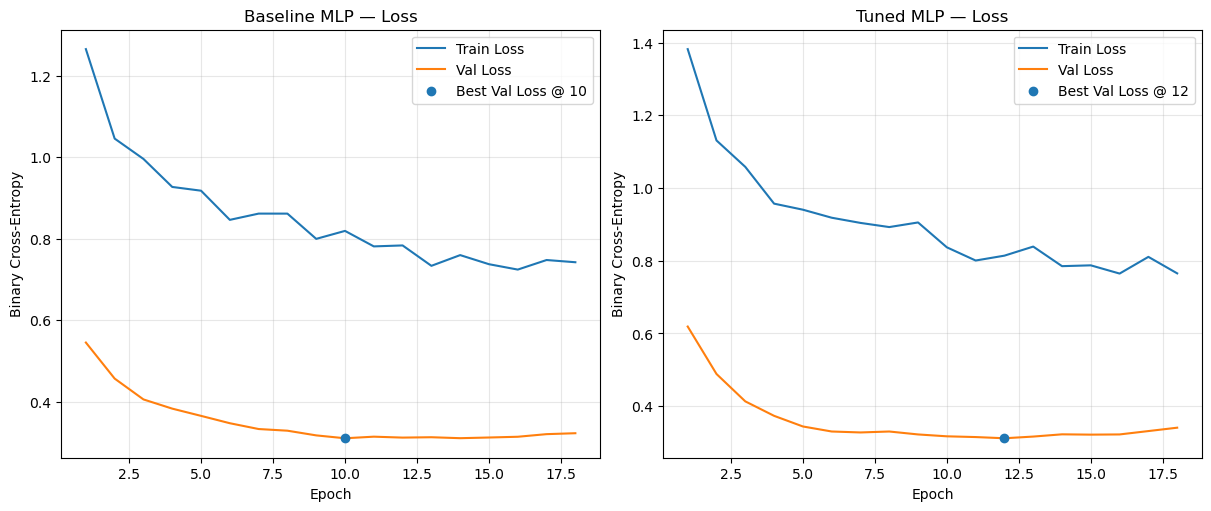

Baseline  ROC-AUC: 0.803 | PR-AUC: 0.160
Tuned     ROC-AUC: 0.829 | PR-AUC: 0.225
Baseline  best F1=0.254 @ thr=0.57
Tuned     best F1=0.312 @ thr=0.48


In [10]:
# ----------------------------
# 4) PLOT: Baseline vs Tuned (Loss)
# ----------------------------
def _plot_loss(ax, hist, title):
    loss = hist.history["loss"]; vloss = hist.history["val_loss"]
    e = np.arange(1, len(loss)+1)
    ax.plot(e, loss, label="Train Loss")
    ax.plot(e, vloss, label="Val Loss")
    be = int(np.argmin(vloss)) + 1
    ax.scatter([be], [vloss[be-1]], zorder=3, label=f"Best Val Loss @ {be}")
    ax.set_title(title); ax.set_xlabel("Epoch"); ax.set_ylabel("Binary Cross-Entropy")
    ax.grid(alpha=0.3); ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
_plot_loss(axes[0], history_baseline, "Baseline MLP — Loss")
_plot_loss(axes[1], history_tuned,    "Tuned MLP — Loss")
plt.show()

# ----------------------------
# 5) TEST-SET COMPARISON (ROC/PR)
# ----------------------------
p_base = baseline_model.predict(X_test, verbose=0).ravel()
p_tuned = final_tuned_model.predict(X_test, verbose=0).ravel()

print(f"Baseline  ROC-AUC: {roc_auc_score(y_test, p_base):.3f} | PR-AUC: {average_precision_score(y_test, p_base):.3f}")
print(f"Tuned     ROC-AUC: {roc_auc_score(y_test, p_tuned):.3f} | PR-AUC: {average_precision_score(y_test, p_tuned):.3f}")

# Threshold selection by F1 for both (show how tuning impacted operating point)
def best_f1_threshold(y_true, p):
    prec, rec, thr = precision_recall_curve(y_true, p)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i])

b_thr, b_f1 = best_f1_threshold(y_test, p_base)
t_thr, t_f1 = best_f1_threshold(y_test, p_tuned)
print(f"Baseline  best F1={b_f1:.3f} @ thr={b_thr:.2f}")
print(f"Tuned     best F1={t_f1:.3f} @ thr={t_thr:.2f}")

ROC-AUC (Baseline): 0.803
ROC-AUC (Tuned): 0.829
PR-AUC (Baseline): 0.160
PR-AUC (Tuned): 0.225



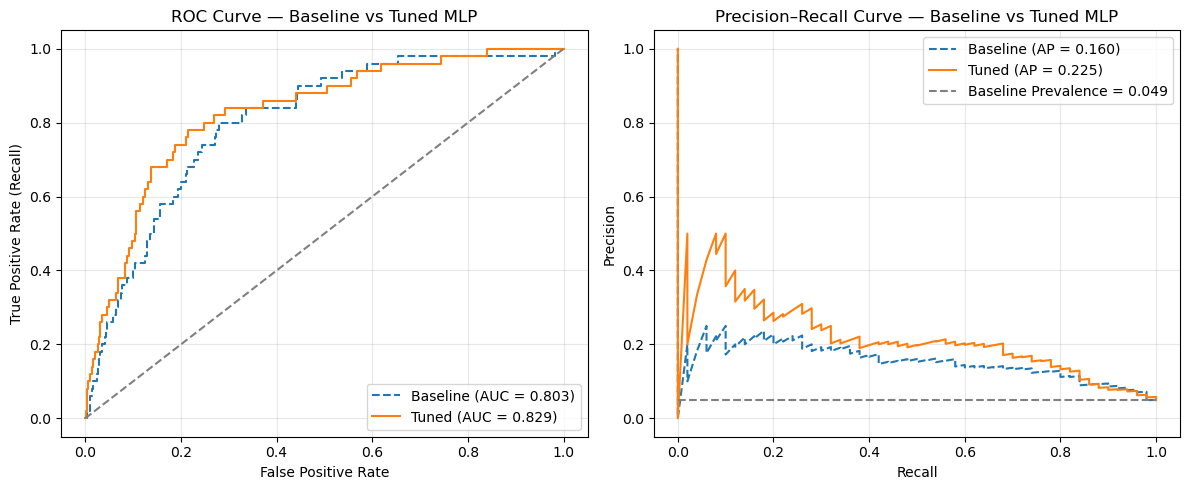

In [11]:
# --- Predict probabilities ---
p_base  = baseline_model.predict(X_test, verbose=0).ravel()
p_tuned = final_tuned_model.predict(X_test, verbose=0).ravel()

# --- Compute metrics ---
roc_base  = roc_auc_score(y_test, p_base)
roc_tuned = roc_auc_score(y_test, p_tuned)

pr_base   = average_precision_score(y_test, p_base)
pr_tuned  = average_precision_score(y_test, p_tuned)

# --- ROC data ---
fpr_base,  tpr_base,  _ = roc_curve(y_test, p_base)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, p_tuned)

# --- PR data (+ baseline positive prevalence) ---
prec_base,  rec_base,  _ = precision_recall_curve(y_test, p_base)
prec_tuned, rec_tuned, _ = precision_recall_curve(y_test, p_tuned)
pos_rate = (y_test == 1).mean()

print(f"ROC-AUC (Baseline): {roc_base:.3f}")
print(f"ROC-AUC (Tuned): {roc_tuned:.3f}")
print(f"PR-AUC (Baseline): {pr_base:.3f}")
print(f"PR-AUC (Tuned): {pr_tuned:.3f}\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ================= ROC PLOT =================
axes[0].plot(fpr_base, tpr_base, linestyle="--", label=f"Baseline (AUC = {roc_base:.3f})")
axes[0].plot(fpr_tuned, tpr_tuned, linestyle="-", label=f"Tuned (AUC = {roc_tuned:.3f})")
axes[0].plot([0,1], [0,1], linestyle="--", color="gray")
axes[0].set_title("ROC Curve — Baseline vs Tuned MLP")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate (Recall)")
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# ================= PR PLOT =================
axes[1].plot(rec_base, prec_base, linestyle="--", label=f"Baseline (AP = {pr_base:.3f})")
axes[1].plot(rec_tuned, prec_tuned, linestyle="-", label=f"Tuned (AP = {pr_tuned:.3f})")
axes[1].hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--", label=f"Baseline Prevalence = {pos_rate:.3f}")
axes[1].set_title("Precision–Recall Curve — Baseline vs Tuned MLP")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(loc="upper right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# --- Find exact best threshold (NO rounding) ---
prec_t, rec_t, thr_t = precision_recall_curve(y_test, p_tuned)
f1_curve = (2 * prec_t[:-1] * rec_t[:-1]) / (prec_t[:-1] + rec_t[:-1] + 1e-12)
best_idx_t = int(np.nanargmax(f1_curve))
best_thr_exact = float(thr_t[best_idx_t])      # keep exact
best_f1_exact  = float(f1_curve[best_idx_t])

# Evaluate at EXACT best threshold (use >= consistently)
y_pred_best = (p_tuned >= best_thr_exact).astype(int)
acc_best = accuracy_score(y_test, y_pred_best)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, average='binary', zero_division=0
)
cm_best = confusion_matrix(y_test, y_pred_best, labels=[0,1])

# Print (display rounded, but DO NOT round the value used)
print("\n=== Tuned MLP Best Threshold Selection ===")
print(f"Best Threshold = {best_thr_exact:.2f}")   # print nice
print(f"F1 (Positive Class) = {f1_best:.3f}")     # now matches
print(f"Accuracy = {acc_best:.3f}\n")
print("Confusion Matrix — Tuned MLP (Best Threshold):")
print(cm_best, "\n")

# ===== Threshold Sweep (including the EXACT best value) =====
print("\n===== Tuned MLP: Testing Different Decision Thresholds =====")

# Build 0.00..1.00 grid and explicitly add the exact best threshold
grid = np.round(np.arange(0.00, 1.01, 0.01), 2)
thr_grid = np.unique(np.r_[grid, best_thr_exact])  # keep exact in the set

def _metrics_at_thr(t):
    yhat = (p_tuned >= t).astype(int)
    acc  = accuracy_score(y_test, yhat)
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, yhat, average='binary', zero_division=0
    )
    cm = confusion_matrix(y_test, yhat, labels=[0,1])
    return acc, p, r, f1, cm

for t in thr_grid:
    acc_t, p_t, r_t, f1_t, cm_t = _metrics_at_thr(t)
    print(f"\n=== Threshold = {t:.2f} ===")
    print(f"Acc: {acc_t:.3f} | Prec: {p_t:.3f} | Rec: {r_t:.3f} | F1: {f1_t:.3f}")
    print("Confusion Matrix:\n", cm_t)


=== Tuned MLP Best Threshold Selection ===
Best Threshold = 0.48
F1 (Positive Class) = 0.312
Accuracy = 0.853

Confusion Matrix — Tuned MLP (Best Threshold):
[[838 134]
 [ 16  34]] 


===== Tuned MLP: Testing Different Decision Thresholds =====

=== Threshold = 0.00 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.01 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.02 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.03 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.04 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.05 ===
Acc: 0.049 | Prec: 0.049 | Rec: 1.000 | F1: 0.093
Confusion Matrix:
 [[  0 972]
 [  0  50]]

=== Threshold = 0.06 ===
Acc: 0.049 | Prec: 0

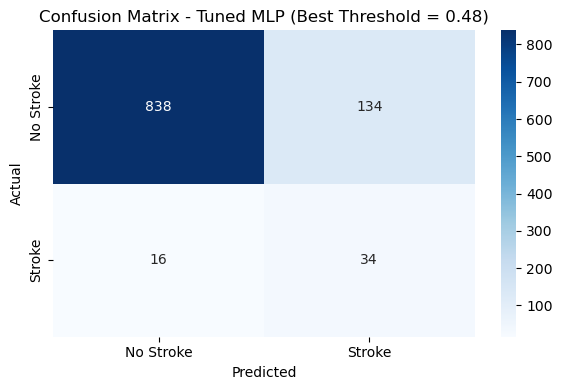

In [13]:
# --- Confusion Matrix (Tuned MLP @ Best Threshold) ---
plt.figure(figsize=(6,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Stroke", "Stroke"],
            yticklabels=["No Stroke", "Stroke"])
plt.title(f"Confusion Matrix - Tuned MLP (Best Threshold = {best_thr_exact:.2f})")
plt.xlabel("Predicted"); 
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Top 10 Important Features — Tuned MLP (Permutation):
age_group_80+: 0.064
age: 0.030
avg_glucose_level: 0.022
work_type_Private: 0.013
age_group_75-79: 0.013
age_group_55-59: 0.010
age_group_10-14: 0.009
age_group_70-74: 0.008
heart_disease_Yes: 0.007
age_group_20-24: 0.007


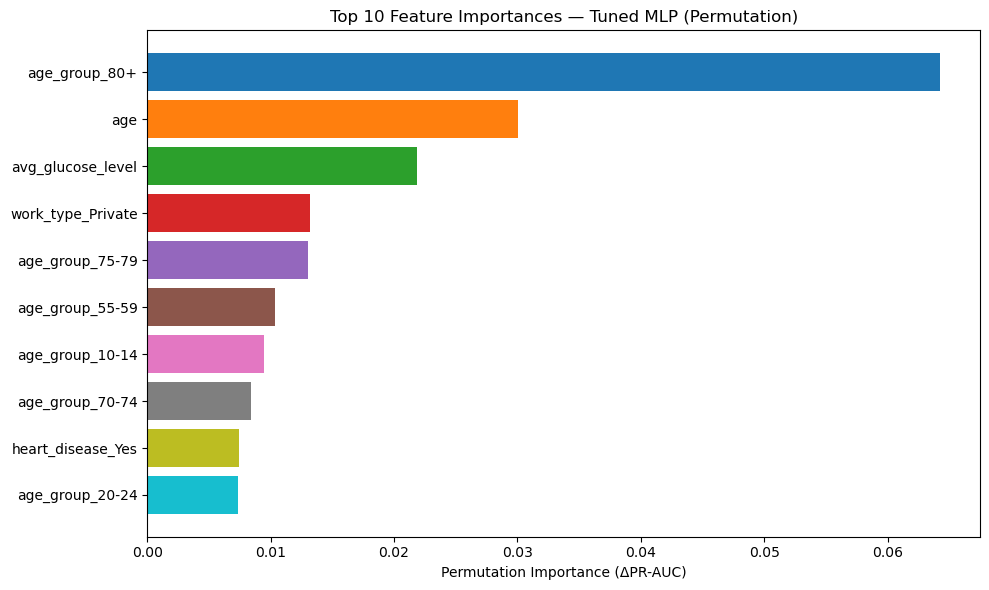

In [14]:
# ==========================================
# Permutation Importance — Tuned MLP
# (importance = drop in PR-AUC when permuted)
# ==========================================

USE_PRAUC = True  # keep PR-AUC since dataset is imbalanced

def _score_tuned(Xb):
    p = final_tuned_model.predict(Xb, verbose=0).ravel()
    if USE_PRAUC:
        return float(average_precision_score(y_test, p))
    # Alternative scoring: F1 at tuned best threshold
    yhat = (p >= best_thr_exact).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(
        y_test, yhat, average="binary", zero_division=0
    )
    return float(f1)

# Baseline score on unshuffled features
base_score_tuned = _score_tuned(X_test)

feat_names = np.array(list(X.columns))
drops_tuned = np.zeros(X_test.shape[1], dtype=float)
rng = np.random.default_rng(42)

# Permutation loop
for j in range(X_test.shape[1]):
    Xp = X_test.copy()
    Xp[:, j] = rng.permutation(Xp[:, j])
    drops_tuned[j] = base_score_tuned - _score_tuned(Xp)

# Top 10 features
indices_tuned = np.argsort(drops_tuned)[::-1][:10]
top_features_tuned = feat_names[indices_tuned]
top_values_tuned   = drops_tuned[indices_tuned]

label_x = "Permutation Importance (ΔPR-AUC)" if USE_PRAUC else "Permutation Importance (ΔF1@thr)"

print("\nTop 10 Important Features — Tuned MLP (Permutation):")
for name, val in zip(top_features_tuned, top_values_tuned):
    print(f"{name}: {val:.3f}")

# Plot
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(top_features_tuned)))
plt.barh(top_features_tuned, top_values_tuned, color=colors)
plt.xlabel(label_x)
plt.title("Top 10 Feature Importances — Tuned MLP (Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [15]:
# ----------------------------
# Helpers
# ----------------------------

# Find the decision threshold that gives the highest F1 score
def best_f1_threshold_from_proba(y_true, proba):
    """Return exact threshold (no rounding) that maximizes F1 for the positive class."""
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i])

def evaluate_at_threshold(y_true, proba, thr):
    """Compute metrics and confusion matrix when classifying with (proba >= thr)."""
    yhat = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, yhat, average='binary', zero_division=0
    )
    cm = confusion_matrix(y_true, yhat, labels=[0,1])
    roc = roc_auc_score(y_true, proba)
    pr  = average_precision_score(y_true, proba)  # PR-AUC (Average Precision)
    return acc, prec, rec, f1, roc, pr, cm

# --- 1) Find exact best thresholds ---
rf_thr,  rf_f1_best  = best_f1_threshold_from_proba(y_test, y_proba) # Random Forest
mlp_thr, mlp_f1_best = best_f1_threshold_from_proba(y_test, p_tuned) # Tuned MLP

# --- 2) Evaluate both models at their own best thresholds ---
rf_acc, rf_prec, rf_rec, rf_f1, rf_roc, rf_pr, rf_cm   = evaluate_at_threshold(y_test, y_proba, rf_thr)
mlp_acc, mlp_prec, mlp_rec, mlp_f1, mlp_roc, mlp_pr, mlp_cm = evaluate_at_threshold(y_test, p_tuned, mlp_thr)

rf_tn, rf_fp, rf_fn, rf_tp     = rf_cm.ravel()
mlp_tn, mlp_fp, mlp_fn, mlp_tp = mlp_cm.ravel()

# --- 3) Comparison table ---
summary = pd.DataFrame({
    "Best Threshold": [rf_thr, mlp_thr],
    "Accuracy":       [rf_acc, mlp_acc],
    "Precision":      [rf_prec, mlp_prec],
    "Recall":         [rf_rec, mlp_rec],
    "F1":             [rf_f1,  mlp_f1],
    "ROC-AUC":        [rf_roc, mlp_roc],
    "PR-AUC":         [rf_pr,  mlp_pr],
    "TN":             [rf_tn,  mlp_tn],
    "FP":             [rf_fp,  mlp_fp],
    "FN":             [rf_fn,  mlp_fn],
    "TP":             [rf_tp,  mlp_tp],
}, index=["Random Forest Classifier", "Tuned MLP"])

with pd.option_context("display.precision", 3):
    print("\n=== Best-Threshold Summary (RFC vs Tuned MLP) ===")
    print(summary)

# Concise one-liners (nice for logs)
print(
    f"\nRFC  @ {rf_thr:.2f} → Acc={rf_acc:.3f}, P={rf_prec:.3f}, R={rf_rec:.3f}, "
    f"F1={rf_f1:.3f}, ROC-AUC={rf_roc:.3f}, PR-AUC={rf_pr:.3f}, CM={rf_cm.tolist()}"
)
print(
    f"MLP* @ {mlp_thr:.2f} → Acc={mlp_acc:.3f}, P={mlp_prec:.3f}, R={mlp_rec:.3f}, "
    f"F1={mlp_f1:.3f}, ROC-AUC={mlp_roc:.3f}, PR-AUC={mlp_pr:.3f}, CM={mlp_cm.tolist()}"
)


=== Best-Threshold Summary (RFC vs Tuned MLP) ===
                          Best Threshold  Accuracy  Precision  Recall     F1  \
Random Forest Classifier           0.575     0.911      0.259    0.44  0.326   
Tuned MLP                          0.476     0.853      0.202    0.68  0.312   

                          ROC-AUC  PR-AUC   TN   FP  FN  TP  
Random Forest Classifier    0.819   0.216  909   63  28  22  
Tuned MLP                   0.829   0.225  838  134  16  34  

RFC  @ 0.57 → Acc=0.911, P=0.259, R=0.440, F1=0.326, ROC-AUC=0.819, PR-AUC=0.216, CM=[[909, 63], [28, 22]]
MLP* @ 0.48 → Acc=0.853, P=0.202, R=0.680, F1=0.312, ROC-AUC=0.829, PR-AUC=0.225, CM=[[838, 134], [16, 34]]


## <font color='red'>Ensemble</font>

### <font color='blue'>Stack</font>

In [16]:
# ============================
# Ensemble: Stacked RF + MLP
# ============================
from sklearn.linear_model import LogisticRegression

# ---- Helpers ----
def _best_f1_threshold(y_true, proba):
    p, r, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * p[:-1] * r[:-1]) / (p[:-1] + r[:-1] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i])

def _evaluate_at_thr(y_true, proba, thr):
    yhat = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, yhat, average="binary", zero_division=0)
    cm = confusion_matrix(y_true, yhat, labels=[0,1])
    return acc, prec, rec, f1, cm

# ---- Ensure best_cfg exists for building the MLP in CV ----
if "best_cfg" not in globals():
    best_cfg = {'units': (256,128,64), 'drop': (0.4,0.3,0.2), 'lr': 0.001, 'batch_size': 256}

# ---- Get OOF probabilities for stacking (no test leakage) ----
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_rf  = np.zeros_like(y_train, dtype=float)
oof_mlp = np.zeros_like(y_train, dtype=float)

for tr_idx, va_idx in kf.split(X_train, y_train):
    X_tr, X_va = X_train[tr_idx], X_train[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]  # y_train is a Series

    # RF fold model
    rf_fold = clone(final_rf)
    rf_fold.fit(X_tr, y_tr)
    oof_rf[va_idx] = rf_fold.predict_proba(X_va)[:, 1]

    # MLP fold model
    tf.keras.backend.clear_session()
    mlp_fold = build_mlp(units=best_cfg['units'], drop=best_cfg['drop'], lr=best_cfg['lr'], d=X_tr.shape[1])
    mlp_fold.fit(
        X_tr, y_tr,
        validation_split=0.1,
        epochs=200,
        batch_size=best_cfg["batch_size"],
        verbose=0,
        class_weight=class_weight,
        callbacks=[early_stop, reduce_lr]
    )
    oof_mlp[va_idx] = mlp_fold.predict(X_va, verbose=0).ravel()

# ---- Train meta-learner on OOF stacks ----
X_oof_stack = np.column_stack([oof_rf, oof_mlp])
meta = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)
meta.fit(X_oof_stack, y_train)

# ---- Build test-time stack features using your final models ----
p_rf_test  = final_rf.predict_proba(X_test)[:, 1]
p_mlp_test = final_tuned_model.predict(X_test, verbose=0).ravel()
X_test_stack = np.column_stack([p_rf_test, p_mlp_test])

# ---- Ensemble probabilities from meta-learner ----
p_stack = meta.predict_proba(X_test_stack)[:, 1]

ROC-AUC (Stack) = 0.831
PR-AUC  (Stack) = 0.259


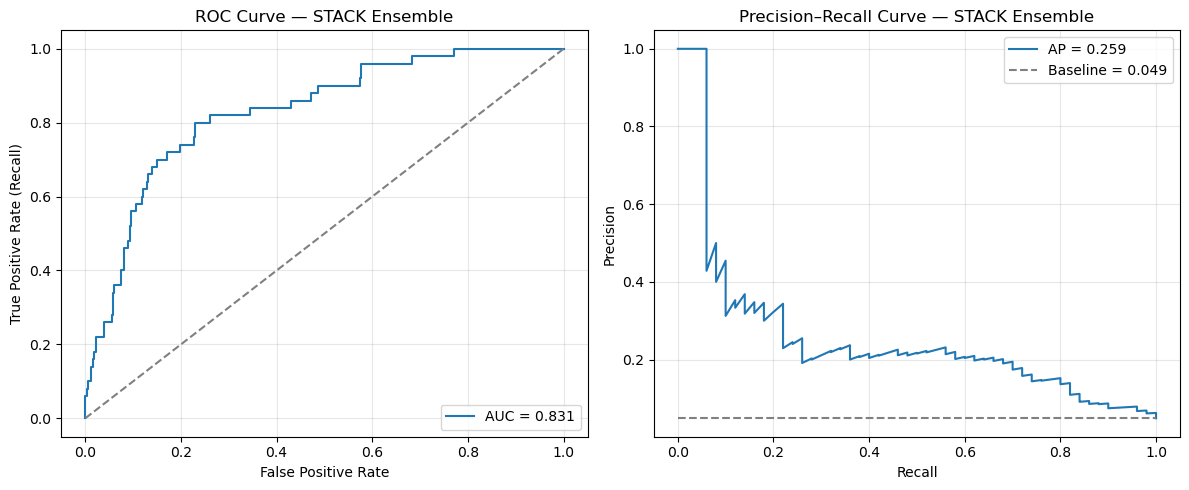

In [17]:
# ---- Report AUCs (same style) ----
roc_stack = roc_auc_score(y_test, p_stack)
pr_stack  = average_precision_score(y_test, p_stack)
print(f"ROC-AUC (Stack) = {roc_stack:.3f}")
print(f"PR-AUC  (Stack) = {pr_stack:.3f}")
# --- Compute curves ---
fpr_stack, tpr_stack, _ = roc_curve(y_test, p_stack)
prec_stk, rec_stk, _    = precision_recall_curve(y_test, p_stack)

# Positive class prevalence (for PR baseline)
pos_rate = (y_test == 1).mean()

plt.figure(figsize=(12,5))

# ===== ROC =====
plt.subplot(1,2,1)
plt.plot(fpr_stack, tpr_stack, label=f"AUC = {roc_stack:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("ROC Curve — STACK Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# ===== PR =====
plt.subplot(1,2,2)
plt.plot(rec_stk, prec_stk, label=f"AP = {pr_stack:.3f}")
plt.hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--",
           label=f"Baseline = {pos_rate:.3f}")
plt.title("Precision–Recall Curve — STACK Ensemble")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# ---- Best F1 threshold for the positive class ----
best_thr_stack, best_f1_stack = _best_f1_threshold(y_test, p_stack)
acc_s, prec_s, rec_s, f1_s, cm_s = _evaluate_at_thr(y_test, p_stack, best_thr_stack)

print(f"\nBest Threshold (Stack) = {best_thr_stack:.2f} (F1 = {best_f1_stack:.3f})")
print(f"Accuracy: {acc_s:.3f}")
print("\nConfusion Matrix — STACK (Best Threshold):\n", cm_s)
print("\nClassification Report — STACK (Best Threshold):\n",
      classification_report(y_test, (p_stack >= best_thr_stack).astype(int),
                            target_names=["No Stroke","Stroke"], digits=3))


Best Threshold (Stack) = 0.71 (F1 = 0.327)
Accuracy: 0.887

Confusion Matrix — STACK (Best Threshold):
 [[879  93]
 [ 22  28]]

Classification Report — STACK (Best Threshold):
               precision    recall  f1-score   support

   No Stroke      0.976     0.904     0.939       972
      Stroke      0.231     0.560     0.327        50

    accuracy                          0.887      1022
   macro avg      0.603     0.732     0.633      1022
weighted avg      0.939     0.887     0.909      1022



In [19]:
# ============================
# Threshold Sweep (STACK)
# ============================

print("\n===== STACK: Threshold Sweep =====")
grid = np.round(np.arange(0.00, 1.01, 0.01), 2)

# Make sure the best threshold is included
thr_grid = np.unique(np.append(grid, best_thr_stack))

for t in thr_grid:
    y_hat_t = (p_stack >= t).astype(int)
    acc_t = accuracy_score(y_test, y_hat_t)
    p_t, r_t, f1_t, _ = precision_recall_fscore_support(
        y_test, y_hat_t, average="binary", zero_division=0
    )
    cm_t = confusion_matrix(y_test, y_hat_t, labels=[0,1])

    print(f"\n--- Threshold = {t:.2f} ---")
    print(f"Accuracy : {acc_t:.3f}")
    print(f"Precision: {p_t:.3f}")
    print(f"Recall   : {r_t:.3f}")
    print(f"F1-Score : {f1_t:.3f}")
    print("Confusion Matrix:")
    print(cm_t)



===== STACK: Threshold Sweep =====

--- Threshold = 0.00 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.01 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.02 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.03 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.04 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.05 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.06 ---
Accuracy : 0.049
Precision: 0.049
Recall   : 1.000
F1-Score : 0.093
Confusion Matrix:
[[  0 972]
 [  0  50]]

--- Threshold = 0.

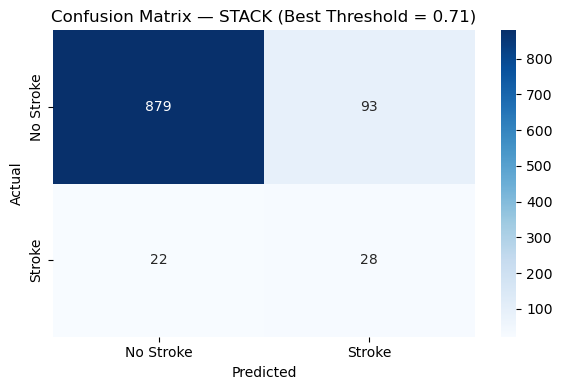

In [20]:
# ---- Plot confusion matrix  ----
plt.figure(figsize=(6,4))
sns.heatmap(cm_s, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Stroke","Stroke"], yticklabels=["No Stroke","Stroke"])
plt.title(f"Confusion Matrix — STACK (Best Threshold = {best_thr_stack:.2f})")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()


Top STACK Feature Contributions (Meta-Learner Coefficients):
RF Probability: 4.3633
MLP Probability: 3.3976


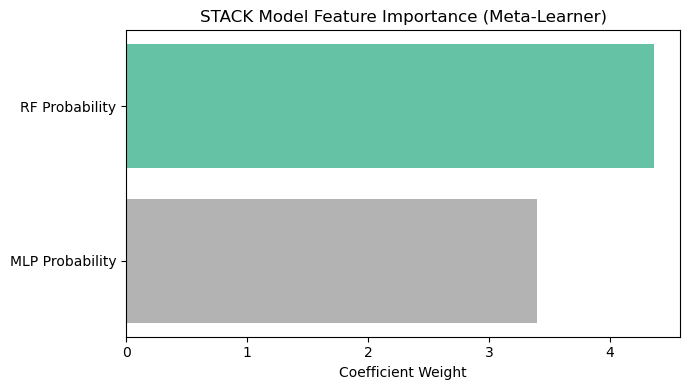

In [21]:
# =========================================
# STACK Feature Importance (Meta-Learner)
# =========================================

# Extract meta-learner from pipeline
meta_lr = meta 

# If pipeline (StandardScaler + LogisticRegression), get last step
if hasattr(meta_lr, "named_steps"):
    meta_lr = meta_lr.named_steps["logisticregression"]

coef = meta_lr.coef_.ravel()
stack_features = ["RF Probability", "MLP Probability"]

# Sort by absolute importance
idx = np.argsort(np.abs(coef))[::-1]
coef = coef[idx]
stack_features = np.array(stack_features)[idx]

print("\nTop STACK Feature Contributions (Meta-Learner Coefficients):")
for name, weight in zip(stack_features, coef):
    print(f"{name}: {weight:.4f}")

# Plot
plt.figure(figsize=(7, 4))
colors = plt.cm.Set2(np.linspace(0, 1, len(stack_features)))
plt.barh(stack_features, coef, color=colors)
plt.xlabel("Coefficient Weight")
plt.title("STACK Model Feature Importance (Meta-Learner)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [22]:
# ============================
# Summary table: RFC vs Tuned MLP vs STACK
# ============================

# --- Helpers ---
def best_f1_threshold_from_proba(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i])

def evaluate_at_threshold(y_true, proba, thr):
    yhat = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, yhat, average='binary', zero_division=0
    )
    cm = confusion_matrix(y_true, yhat, labels=[0,1])
    roc = roc_auc_score(y_true, proba)
    pr  = average_precision_score(y_true, proba)  # PR-AUC (Average Precision)
    return acc, prec, rec, f1, roc, pr, cm

# 1) Best thresholds
rf_thr,  _ = best_f1_threshold_from_proba(y_test, y_proba)
mlp_thr, _ = best_f1_threshold_from_proba(y_test, p_tuned)
stk_thr, _ = best_f1_threshold_from_proba(y_test, p_stack)

# 2) Evaluate each model at its own best threshold
rf_acc, rf_prec, rf_rec, rf_f1, rf_roc, rf_pr, rf_cm   = evaluate_at_threshold(y_test, y_proba, rf_thr)
mlp_acc, mlp_prec, mlp_rec, mlp_f1, mlp_roc, mlp_pr, mlp_cm = evaluate_at_threshold(y_test, p_tuned,  mlp_thr)
stk_acc, stk_prec, stk_rec, stk_f1, stk_roc, stk_pr, stk_cm = evaluate_at_threshold(y_test, p_stack,  stk_thr)

# 3) Unpack confusion matrices
rf_tn, rf_fp, rf_fn, rf_tp     = rf_cm.ravel()
mlp_tn, mlp_fp, mlp_fn, mlp_tp = mlp_cm.ravel()
stk_tn, stk_fp, stk_fn, stk_tp = stk_cm.ravel()

# 4) Build tidy DataFrame
summary = pd.DataFrame({
    "Best Threshold": [round(rf_thr, 2), round(mlp_thr, 2), round(stk_thr, 2)],
    "Accuracy":       [rf_acc, mlp_acc, stk_acc],
    "Precision":      [rf_prec, mlp_prec, stk_prec],
    "Recall":         [rf_rec, mlp_rec, stk_rec],
    "F1":             [rf_f1,  mlp_f1,  stk_f1],
    "ROC-AUC":        [rf_roc, mlp_roc, stk_roc],
    "PR-AUC":         [rf_pr,  mlp_pr,  stk_pr],
    "TN":             [rf_tn,  mlp_tn,  stk_tn],
    "FP":             [rf_fp,  mlp_fp,  stk_fp],
    "FN":             [rf_fn,  mlp_fn,  stk_fn],
    "TP":             [rf_tp,  mlp_tp,  stk_tp],
}, index=["Random Forest Classifier", "Tuned MLP", "STACK"])

# 5) Print Summary
with pd.option_context("display.precision", 3):
    print("\n=== Best-Threshold Summary (RF vs Tuned MLP vs STACK) ===")
    print(summary)

# 7) Concise one-liners (good for logs)
print(
    f"\nRFC   @ {rf_thr:.2f} → Acc={rf_acc:.3f}, P={rf_prec:.3f}, R={rf_rec:.3f}, "
    f"F1={rf_f1:.3f}, ROC-AUC={rf_roc:.3f}, PR-AUC={rf_pr:.3f}, CM={rf_cm.tolist()}"
)
print(
    f"MLP*  @ {mlp_thr:.2f} → Acc={mlp_acc:.3f}, P={mlp_prec:.3f}, R={mlp_rec:.3f}, "
    f"F1={mlp_f1:.3f}, ROC-AUC={mlp_roc:.3f}, PR-AUC={mlp_pr:.3f}, CM={mlp_cm.tolist()}"
)
print(
    f"STACK @ {stk_thr:.2f} → Acc={stk_acc:.3f}, P={stk_prec:.3f}, R={stk_rec:.3f}, "
    f"F1={stk_f1:.3f}, ROC-AUC={stk_roc:.3f}, PR-AUC={stk_pr:.3f}, CM={stk_cm.tolist()}"
)


=== Best-Threshold Summary (RF vs Tuned MLP vs STACK) ===
                          Best Threshold  Accuracy  Precision  Recall     F1  \
Random Forest Classifier            0.57     0.911      0.259    0.44  0.326   
Tuned MLP                           0.48     0.853      0.202    0.68  0.312   
STACK                               0.71     0.887      0.231    0.56  0.327   

                          ROC-AUC  PR-AUC   TN   FP  FN  TP  
Random Forest Classifier    0.819   0.216  909   63  28  22  
Tuned MLP                   0.829   0.225  838  134  16  34  
STACK                       0.831   0.259  879   93  22  28  

RFC   @ 0.57 → Acc=0.911, P=0.259, R=0.440, F1=0.326, ROC-AUC=0.819, PR-AUC=0.216, CM=[[909, 63], [28, 22]]
MLP*  @ 0.48 → Acc=0.853, P=0.202, R=0.680, F1=0.312, ROC-AUC=0.829, PR-AUC=0.225, CM=[[838, 134], [16, 34]]
STACK @ 0.71 → Acc=0.887, P=0.231, R=0.560, F1=0.327, ROC-AUC=0.831, PR-AUC=0.259, CM=[[879, 93], [22, 28]]
